In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency

In [123]:
# 1. Loading data
df = pd.read_csv("./data/Input_data.csv")

# 1.1 Cleaning data
# Elimination of the least informative variables
cols_to_drop = ['property_ID','locality_name','postal_code','type','subtype','open_fire','terrace_area','number_facades','price_per_m2','province','region']
df = df.drop(columns=cols_to_drop)
df = df[df['living_area'] <= 1000] # exclude property with living_area > 1000 m2 (22 objects = 0,15%)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14523 entries, 0 to 14544
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   property_type       14523 non-null  object 
 1   price               14523 non-null  int64  
 2   number_of_bedrooms  14376 non-null  float64
 3   living_area         14523 non-null  int64  
 4   equiped_kitchen     14523 non-null  int64  
 5   furnished           14523 non-null  int64  
 6   terrace             14523 non-null  int64  
 7   garden              14523 non-null  int64  
 8   swimming_pool       14523 non-null  int64  
 9   state_of_building   11613 non-null  object 
 10  municipality        14523 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 1.3+ MB


In [124]:
# 2. Defining column types
def detect_column_type(series, cat_threshold=15):
    if pd.api.types.is_numeric_dtype(series):
        if series.nunique() == 2:
            return "binary"
        else:
            return "numerical"
    else:
        if series.nunique() == 2:
            return "binary"
        elif series.nunique() <= cat_threshold:
            return "categorical"
        else:
            return "categorical"

column_types = {col: detect_column_type(df[col]) for col in df.columns}
print("\nColumn types:")
for col, tp in column_types.items():
    print(f"{col}: {tp}")


Column types:
property_type: categorical
price: numerical
number_of_bedrooms: numerical
living_area: numerical
equiped_kitchen: binary
furnished: binary
terrace: binary
garden: binary
swimming_pool: binary
state_of_building: categorical
municipality: categorical


In [125]:
# 3. Functions for calculating correlation

# Convert a 2-class categorical series to 0/1
def encode_binary(series):

    if series.nunique() != 2:
        return series
    classes = list(series.unique())
    mapping = {classes[0]: 0, classes[1]: 1}
    return series.map(mapping)

# Eta_squared: Numerical vs Categorical
def eta_squared(df, numerical, categorical):
    groups = df.groupby(categorical)[numerical]
    ss_between = sum([len(g) * (g.mean() - df[numerical].mean())**2 for name, g in groups])
    ss_total = sum((df[numerical] - df[numerical].mean())**2)
    return ss_between / ss_total if ss_total != 0 else 0

# Spearman: Numerical vs Numerical
def safe_spearman(a, b):
    a_num = pd.to_numeric(a, errors='coerce')
    b_num = pd.to_numeric(b, errors='coerce')
    mask = a_num.notna() & b_num.notna()
    if mask.sum() < 3:
        return np.nan
    val, _ = spearmanr(a_num[mask], b_num[mask])
    return val

# Point-Biserial: Binary vs Numerical
def safe_pointbiserial(numeric, binary):
    numeric = pd.to_numeric(numeric, errors='coerce')
    binary = pd.to_numeric(binary, errors='coerce')
    mask = numeric.notna() & binary.notna()
    if mask.sum() < 3:
        return np.nan
    try:
        val, _ = pointbiserialr(numeric[mask], binary[mask])
        return val
    except Exception:
        return np.nan

In [126]:
# 4. Construction of a “correlation vector” with "price (€)"
def correlation_value(x, y, type_x, type_y):
    try:
        # numerical-numerical
        if type_x == "numerical" and type_y == "numerical":
            return safe_spearman(x, y)

        # numerical-binary
        if type_x == "binary" and type_y == "numerical":
            return safe_pointbiserial(encode_binary(x), y)
        if type_x == "numerical" and type_y == "binary":
            return safe_pointbiserial(x, encode_binary(y))

        # numerical-categorical
        if type_x == "numerical" and type_y == "categorical":
            return eta_squared(df, x.name, y.name)

        if type_x == "categorical" and type_y == "numerical":
            return eta_squared(df, y.name, x.name)

        # binary-binary
        if type_x == "binary" and type_y == "binary":
            return phi_coefficient(x, y)

        # categorical-categorical
        if type_x == "categorical" and type_y == "categorical":
            return cramers_v(x, y)

    except Exception:
        return np.nan

    return np.nan

columns = df.columns

target = "state_of_building"           # field to compare with
corr_vector = {}           # Let's add the correlations here

for col in df.columns:
    if col == target:
        continue
    t1 = column_types[col]
    t2 = column_types[target]
    corr_vector[col] = correlation_value(df[col], df[target], t1, t2)

corr_vector = pd.Series(corr_vector).sort_values(ascending=False)

print("\nMixed correlation vector with target:", target)
# print(corr_vector)
print(corr_vector.abs().sort_values(ascending=False))


Mixed correlation vector with target: state_of_building
living_area           0.075192
price                 0.041190
property_type              NaN
number_of_bedrooms         NaN
equiped_kitchen            NaN
furnished                  NaN
terrace                    NaN
garden                     NaN
swimming_pool              NaN
municipality               NaN
dtype: float64


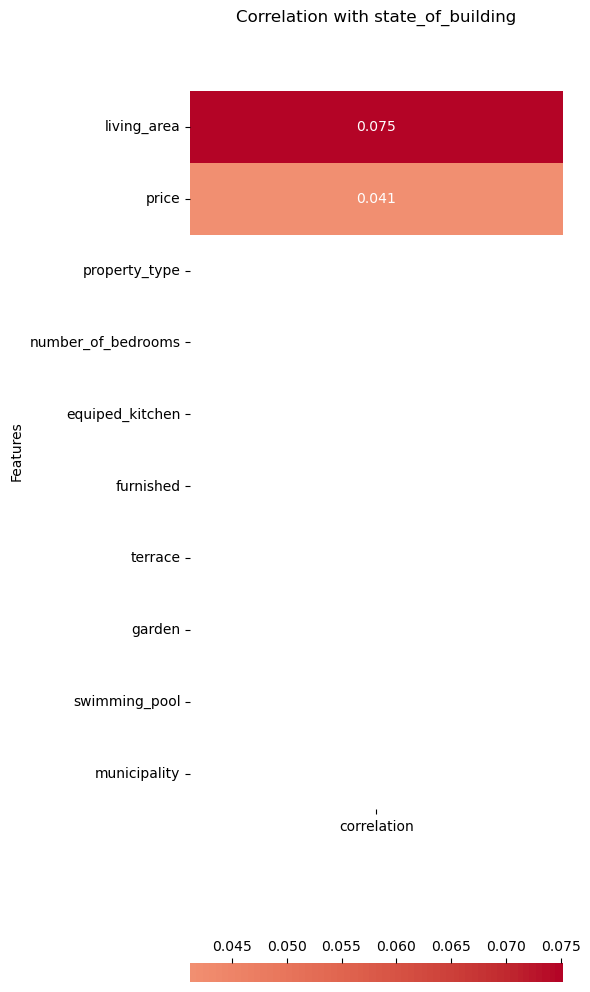

In [127]:
# 5. Visualization of a mixed matrix
plt.figure(figsize=(6, 12))

# seaborn heatmap expects a 2D matrix → convert Series to DataFrame
corr_df = corr_vector.to_frame(name="correlation")

ax = sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_kws={"orientation": "horizontal"}
)

plt.title(f"Correlation with {target}", pad=50)

# Get existing colorbar
cbar = ax.collections[0].colorbar

# Move ticks to the top of colorbar
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.tick_top()

# Reposition colorbar under the title
bbox = ax.get_position()
cbar.ax.set_position([bbox.x0, bbox.y1 + 0.03, bbox.width, 0.02])

ax.set_xlabel("")
ax.set_ylabel("Features")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for colorbar and title

plt.show()

In [128]:
# 6. Top 5 Strongest Relationships
top5 = corr_vector.abs().sort_values(ascending=False).head(5)
top5 = corr_vector.loc[top5.index]
top5

living_area           0.075192
price                 0.041190
property_type              NaN
number_of_bedrooms         NaN
equiped_kitchen            NaN
dtype: float64


TOP-5 strongest correlations with price (€):
living_area           0.075192
price                 0.041190
property_type              NaN
number_of_bedrooms         NaN
equiped_kitchen            NaN
dtype: float64


ValueError: could not convert string to float: 'Excellent'

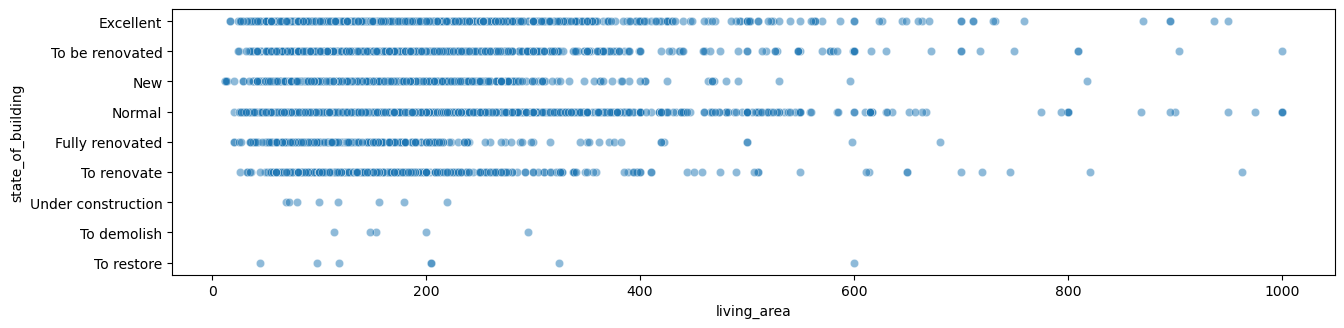

In [129]:
# 7. Visualization of the TOP-5 strongest connections
top5 = corr_vector.abs().sort_values(ascending=False).head(5)
top5 = corr_vector.loc[top5.index]   # restore ± sign

print("\nTOP-5 strongest correlations with price (€):")
print(top5)

# --- Visualization of TOP-5 as individual plots ---
plt.figure(figsize=(15, 20))

for i, feature in enumerate(top5.index, 1):
    plt.subplot(5, 1, i)

    ftype = column_types[feature]

    # Numerical vs Numerical → SCATTERPLOT + TREND LINE
    if ftype == "numerical":
        # scatter
        sns.scatterplot(data=df, x=feature, y=target, alpha=0.5)
        
        # ---- trend line ----
        # drop NaN
        x = df[feature].astype(float)
        y = df[target].astype(float)
        mask = x.notna() & y.notna()

        if mask.sum() > 2:
            # linear regression
            slope, intercept = np.polyfit(x[mask], y[mask], 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept

            plt.plot(x_line, y_line, linewidth=2)

        plt.title(f"{feature} vs {target} (numerical → scatter + trend line)")
        plt.xlabel(feature)
        plt.ylabel(target)

    # Binary vs Numerical → BOXPLOT (trend line NOT applicable)
    elif ftype == "binary":
        sns.boxplot(data=df, x=feature, y=target)
        plt.title(f"{feature} vs {target} (binary → boxplot)")
        plt.xlabel(feature)
        plt.ylabel(target)

    # Categorical vs Numerical → BOXPLOT (trend line NOT applicable)
    elif ftype == "categorical":
        # Если категорий слишком много — показывать только top-10 самых частых
        if df[feature].nunique() > 10:
            top_categories = df[feature].value_counts().head(10).index
            sub_df = df[df[feature].isin(top_categories)]
            sns.boxplot(data=sub_df, x=feature, y=target)
            plt.title(f"{feature} vs {target} (categorical, top-10 categories)")
        else:
            sns.boxplot(data=df, x=feature, y=target)
            plt.title(f"{feature} vs {target} (categorical → boxplot)")

        plt.xlabel(feature)
        plt.ylabel(target)

    plt.tight_layout()

plt.show()